In [1]:
from truthnet import truthnet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm
import tikzplotlib as tpl
from datetime import datetime
import glob
from zedstat import zedstat

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    auc,
    mean_squared_error,
    precision_recall_curve,
    r2_score,
    roc_curve,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
import optuna

# optuna.logging.set_verbosity(optuna.logging.WARNING)

In [3]:
def _get_qnet(df):
    from quasinet import qnet

    qn = qnet.Qnet(
        feature_names=df.columns.values,
        min_samples_split=2,
        alpha=0.05,
        max_depth=-1,
        max_feats=-1,
        early_stopping=False,
        verbose=0,
        random_state=None,
        n_jobs=-1,
    )

    qn.fit(df.to_numpy(dtype="<U21"))

    return qn


def _get_tnets(df, df_pos, df_neg):
    non_null_cols = (
        (df.isna().sum() < len(df))
        & (df_pos.isna().sum() < len(df_pos))
        & (df_neg.isna().sum() < len(df_neg))
    )

    Tr = _get_qnet(df.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, ""))
    Tr_pos = _get_qnet(
        df_pos.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
    )
    Tr_neg = _get_qnet(
        df_neg.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
    )

    return {"all": Tr, "pos": Tr_pos, "neg": Tr_neg}


from scipy.stats import entropy
import random
from quasinet.utils import sample_from_dict


def _diss_linear(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(1 - Ds[i][s[i]] / np.max(list(Ds[i].values())))
            else:
                diss.append(1)

    return np.array(diss)


def _diss_log(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(-np.log(Ds[i][s[i]]))
            else:
                diss.append(np.inf)

    return np.array(diss)


def _sample_with_dissonance(
    sample_model, length, diss_models, diss_fcn=_diss_linear, order=None
):
    if order is None:
        order = range(length)

    sample = np.full(length, "")

    diss = [list() for model in diss_models]

    feature_vecs = list()

    for i in order:
        prob_dict = sample_model.predict_distribution(sample, i)
        sample[i] = sample_from_dict(prob_dict)
        [d.append(diss_fcn(sample, model)) for d, model in zip(diss, diss_models)]

    return sample, diss


def _nsamples_with_dissonance(
    n_samples, sample_model, length, diss_models, diss_fcn=_diss_linear, order=None
):
    samples = list()
    dissonances = list()

    for i in tqdm(range(n_samples)):
        samp, diss = _sample_with_dissonance(
            sample_model, length, diss_models, diss_fcn, order
        )
        samples.append(samp)
        dissonances.append(diss)

    return samples, dissonances


def _dissonance_data_at_question(dissonances, questions_asked):
    return np.array(
        [np.hstack([d[questions_asked - 1] for d in diss]) for diss in dissonances]
    )


# generate samples under the given models and compute dissonances under specified diss_models
def _sampling_scenario(
    n_qsamples,
    qsample_model,
    n_m2_samples,
    m2_model,
    diss_models,
    length,
    diss_fcn=_diss_linear,
    order=None,
):
    samples = {}
    dissonances = {}

    if order == "entropy":
        Ds = qsample_model.predict_distributions(np.full(length, ""))
        entrpy = list()
        for i in range(len(Ds)):
            entrpy.append(entropy(np.fromiter(Ds[i].values(), dtype=float)))
        order = pd.Series(entrpy).sort_values().index

    samples["qsampled"], dissonances["qsampled"] = _nsamples_with_dissonance(
        n_qsamples, qsample_model, length, diss_models, diss_fcn, order
    )

    samples["m2"], dissonances["m2"] = _nsamples_with_dissonance(
        n_m2_samples, m2_model, length, diss_models, diss_fcn, order
    )

    return samples, dissonances


def _diss_dataset(dissonances, questions_asked):
    diss_dataset = pd.concat(
        [
            pd.DataFrame(
                _dissonance_data_at_question(dissonances[group], questions_asked)
            ).assign(y=group)
            for group in ["qsampled", "m2"]
        ]
    )
    return diss_dataset


def _save_sampling_scenarios(
    n, n_qsamples, n_m2_samples, diss_fcn=_diss_linear, order=None
):
    for i in tqdm(range(n)):
        glbl = _get_tnets(
            pd.read_csv("data/gibbons_global/gibbons_global.csv"),
            pd.read_csv("data/gibbons_global/gibbons_global_pos.csv"),
            pd.read_csv("data/gibbons_global/gibbons_global_neg.csv"),
        )

        full_model = glbl["all"]
        pos_model = glbl["pos"]
        neg_model = glbl["neg"]

        length = len(full_model.feature_names)

        diss_models = [full_model, neg_model, pos_model]

        s, d = _sampling_scenario(
            n_qsamples,
            full_model,
            n_m2_samples,
            pos_model,
            diss_models,
            length,
            diss_fcn,
            order,
        )

        pd.to_pickle(s, "samps_global_" + str(i) + ".pkl")
        pd.to_pickle(d, "disson_global_" + str(i) + ".pkl")

In [ ]:
full_model = glbl["all"]
pos_model = glbl["pos"]
neg_model = glbl["neg"]

diss_models = [full_model, neg_model, pos_model]
n_qsamples = 10
n_m2_samples = 10

s, d = _sampling_scenario(
    n_qsamples,
    full_model,
    n_m2_samples,
    pos_model,
    diss_models,
    len(full_model.feature_names),
)

In [ ]:
_save_sampling_scenarios(10, 50, 50, order="entropy")

## Classification

In [3]:
diss = [pd.read_pickle(d) for d in glob.glob("disson_global/disson*.pkl")]

Quick test

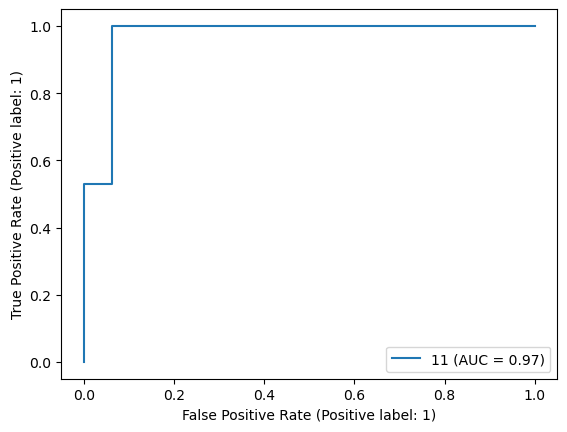

In [10]:
data = _diss_dataset(diss[0], 50)
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("y", axis="columns"), data["y"], test_size=0.33
)

fig, ax = plt.subplots()

classifier = RandomForestClassifier(n_jobs=-1)

classifier.fit(
    X_train.to_numpy(),
    y_train.replace(
        {
            "qsampled": 0,
            "m2": 1,
        }
    ),
)

r = RocCurveDisplay.from_estimator(
    classifier,
    X_test.to_numpy(),
    y_test.replace(
        {
            "qsampled": 0,
            "m2": 1,
        }
    ),
    pos_label=1,
    ax=ax,
    name=questions_asked,
)

Below, note that each dissonance file contains dissonances computed on retrained qnets (one set of qnets per file).  We also fit a classifier `retrains` times to get average performance on each file/set of models.

In [ ]:
auc_dfs = list()
plot = False
retrains = 3
n_trials = 20
question_iter = range(1, 102, 5)
res = "all_diss"

classifier = RandomForestClassifier(n_jobs=-1)
# classifier = lgb.LGBMClassifier()


# for each dissonance file
for d in tqdm(diss, desc="Dissonance files"):
    # repeat performance calc
    for _ in tqdm(range(retrains), desc="Training cycles this file"):
        fig, ax = plt.subplots()
        aucs = list()
        z_aucs = list()
        z_aucs_lb = list()
        z_aucs_ub = list()
        roc_dfs = list()

        # which computes the auc for classifier at each question marker
        for questions_asked in question_iter:
            data = _diss_dataset(d, questions_asked)
            X_train, X_test, y_train, y_test = train_test_split(
                data.drop("y", axis="columns"), data["y"], test_size=0.33
            )

            # X_train = X_train.mean(axis=1)
            # X_test = X_test.mean(axis=1)

            def objective(trial):
                # pruning_callback = optuna.integration.LightGBMPruningCallback(
                #    trial, "auc"
                # )

                param = {
                    "n_estimators": trial.suggest_int("n_estimators", 50, 250),
                    "max_depth": trial.suggest_int("max_depth", 5, 15),
                    "min_samples_split": trial.suggest_int("min_samples_split", 10, 30),
                }
                # param = {
                #    "objective": "binary",
                #    "metric": "auc",
                #    "verbosity": -1,
                #    "boosting_type": "gbdt",
                #    "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
                #    "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
                #    "num_leaves": trial.suggest_int("num_leaves", 2, 256),
                #    "feature_fraction": trial.suggest_float(
                #        "feature_fraction", 0.4, 1.0
                #    ),
                #    "bagging_fraction": trial.suggest_float(
                #        "bagging_fraction", 0.4, 1.0
                #    ),
                #    "bagging_freq": trial.suggest_int("bagging_freq", 1, #7),
                #    "min_child_samples": trial.suggest_int#("min_child_samples", 5, 100),
                # }

                classifier.set_params(**param)
                classifier.fit(
                    X_train.to_numpy(),
                    y_train.replace(
                        {
                            "qsampled": 0,
                            "m2": 1,
                        }
                    ),
                    # callbacks=[pruning_callback],
                )

                r = RocCurveDisplay.from_estimator(
                    classifier,
                    X_test.to_numpy(),
                    y_test.replace(
                        {
                            "qsampled": 0,
                            "m2": 1,
                        }
                    ),
                    pos_label=1,
                    ax=ax,
                    name=questions_asked,
                )

                return r.roc_auc

            study = optuna.create_study(
                # pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
                direction="maximize",
            )
            func = lambda trial: objective(trial, param)
            study.optimize(objective, n_trials=n_trials)

            classifier.set_params(**study.best_trial.params)
            classifier.fit(
                X_train.to_numpy(),
                y_train.replace(
                    {
                        "qsampled": 0,
                        "m2": 1,
                    }
                ),
            )

            r = RocCurveDisplay.from_estimator(
                classifier,
                X_test.to_numpy(),
                y_test.replace(
                    {
                        "qsampled": 0,
                        "m2": 1,
                    }
                ),
                pos_label=1,
                ax=ax,
                name=questions_asked,
            )
            aucs.append(r.roc_auc)
            fpr, tpr, thresholds = roc_curve(
                y_test.replace(
                    {
                        "qsampled": 0,
                        "m2": 1,
                    }
                ),
                classifier.predict_proba(X_test.to_numpy())[:, 1],
                pos_label=1,
            )
            roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thresholds})
            roc_dfs.append(roc_df)
            if plot is False:
                plt.close()

            try:
                zt = zedstat.processRoc(
                    roc_df,
                    order=3,
                    total_samples=1000,
                    positive_samples=150,
                    alpha=0.01,
                    prevalence=0.15,
                )

                zt.smooth(STEP=0.01)
                zt.allmeasures(interpolate=False)
                zt.usample(precision=3)
                zt.getBounds()
                z_aucs.append(zt.auc()[0])
                z_aucs_lb.append(zt.auc()[2])
                z_aucs_ub.append(zt.auc()[1])
            except:
                z_aucs.append(r.roc_auc)
                z_aucs_lb.append(r.roc_auc)
                z_aucs_ub.append(r.roc_auc)

        auc_df = pd.DataFrame(
            {
                "questions asked": question_iter,
                "auc": aucs,
                "z_auc": z_aucs,
                "z_auc_lb": z_aucs_lb,
                "z_auc_ub": z_aucs_ub,
            }
        )

        if plot is True:
            ax = auc_df.plot(x="questions asked", y="z_auc")
            ax.fill_between(
                auc_df["questions asked"],
                auc_df["z_auc_ub"],
                auc_df["z_auc_lb"],
                alpha=0.25,
            )

        auc_dfs.append(auc_df)
        auc_df.to_csv(
            "data/classification/global/lgbm_auc_res/auc_df_lgbm_"
            + str(datetime.now())
            + ".csv",
            index=False,
        )
    pd.concat(auc_dfs).groupby(level=0).mean().to_csv(
        "data/classification/global/lgbm_auc_res/auc_dfs_lgbm_"
        + str(datetime.now())
        + ".csv",
        index=False,
    )

# results[res][str(classifier) + "_" + str(classifier.get_params())] = (
#    pd.concat(auc_dfs).groupby(level=0).mean()
# )

# results

Random forest results for first 50 questions:

In [58]:
conf = 0.95

rf_res = pd.concat(
    [
        pd.read_csv(df)
        for df in glob.glob("data/classification/global/rf_auc_res/auc_df_rf*.csv")
    ]
)

rf_auc_ci_var = rf_res.groupby(["questions asked"], as_index=False).agg(
    mean=pd.NamedAgg(column="auc", aggfunc="mean"),
    var=pd.NamedAgg(column="auc", aggfunc="var"),
    ci=pd.NamedAgg(
        column="auc",
        aggfunc=lambda x: sms.DescrStatsW(x).tconfint_mean(alpha=1 - conf),
    ),
)

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns")

,questions asked,mean,var,lower,upper
0,1,0.500000,0.000000,0.500000,0.500000
1,6,0.500000,0.000000,0.500000,0.500000
2,11,0.530833,0.003244,0.509566,0.552101
3,16,0.571094,0.006789,0.540328,0.601859
4,21,0.650546,0.011094,0.611216,0.689876
5,26,0.667312,0.012997,0.624742,0.709881
6,31,0.986024,0.000265,0.979948,0.992099
7,36,0.979935,0.000446,0.972054,0.987817
8,41,0.978873,0.000469,0.970785,0.986961
9,46,0.979944,0.000569,0.971034,0.988855


In [3]:
conf = 0.95

rf_res = pd.concat(
    [
        pd.read_csv(df)
        for df in glob.glob("data/classification/global/rf_auc_res/auc_df_rf*.csv")
    ]
)

rf_auc_ci_var = rf_res.groupby(["questions asked"], as_index=False).agg(
    mean=pd.NamedAgg(column="auc", aggfunc="mean"),
    var=pd.NamedAgg(column="auc", aggfunc="var"),
    ci=pd.NamedAgg(
        column="auc",
        aggfunc=lambda x: sms.DescrStatsW(x).tconfint_mean(alpha=1 - conf),
    ),
)

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns")

,questions asked,mean,var,lower,upper
0,1,0.500000,0.000000e+00,0.500000,0.500000
1,6,0.500000,0.000000e+00,0.500000,0.500000
2,11,0.531751,3.979134e-03,0.515456,0.548046
3,16,0.574353,7.606620e-03,0.551823,0.596883
4,21,0.647969,1.039181e-02,0.621635,0.674303
5,26,0.653670,1.061430e-02,0.627055,0.680284
6,31,0.986506,2.235031e-04,0.982644,0.990368
7,36,0.981396,3.695364e-04,0.976430,0.986362
8,41,0.979627,4.168442e-04,0.974353,0.984901
9,46,0.980165,4.552183e-04,0.974653,0.985677


In [4]:
rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns").to_csv(
    "data/classification/global/global_rf_auc_ci_var.csv", index=False
)

# Dissonance comparison

In [4]:
df = pd.read_csv("data/gibbons_global/gibbons_global.csv")
df_pos = pd.read_csv("data/gibbons_global/gibbons_global_pos.csv")
df_neg = pd.read_csv("data/gibbons_global/gibbons_global_neg.csv")

non_null_cols = (
    (df.isna().sum() < len(df))
    & (df_pos.isna().sum() < len(df_pos))
    & (df_neg.isna().sum() < len(df_neg))
)

glbl = _get_tnets(
    df,
    df_pos,
    df_neg,
)

In [5]:
def _compare_dissonance(
    samples, qnet, qnet_pos, order=None, diss_fcn=_diss_linear, plot=True
):
    samples_df = pd.DataFrame(samples)
    sample_values = pd.Series(
        {
            col: np.array([x for x in samples_df[col].unique() if x != ""])
            for col in samples_df
        }
    )
    # sample_values = pd.Series({col: samples_df[col].unique() for col in samples_df})

    if order is None:
        order = range(len(samples[0]))

    mean_diss_random = list()
    mean_diss_qsampled = list()
    mean_diss_qsampled_pos = list()
    mean_diss_m2 = list()
    mean_diss_m2_pos = list()
    mean_diss_m3 = list()

    new_samp_r = np.full_like(samples[0], fill_value="")
    new_samp_q = np.full_like(samples[0], fill_value="")
    new_samp_q_pos = np.full_like(samples[0], fill_value="")
    new_samp_m2 = np.full_like(samples[0], fill_value="")
    new_samp_m2_pos = np.full_like(samples[0], fill_value="")
    new_samp_m3 = np.full_like(samples[0], fill_value="")

    for i in order:
        # generate answers randomly
        new_samp_r[i] = random.choice(sample_values[i])
        mean_diss_random.append(
            np.mean(np.ma.masked_invalid(diss_fcn(new_samp_r, qnet)))
        )

        # baseline/comparison answers (generated from full model)
        prob_dict = qnet.predict_distribution(new_samp_q, i)
        new_samp_q[i] = sample_from_dict(prob_dict)
        mean_diss_qsampled.append(
            np.mean(np.ma.masked_invalid(diss_fcn(new_samp_q, qnet)))
        )
        mean_diss_qsampled_pos.append(
            np.mean(np.ma.masked_invalid(diss_fcn(new_samp_q, qnet_pos)))
        )

        # generate answers from positive qnet distributions
        prob_dict_pos = qnet_pos.predict_distribution(new_samp_m2, i)
        new_samp_m2[i] = sample_from_dict(prob_dict_pos)
        mean_diss_m2.append(np.mean(np.ma.masked_invalid(diss_fcn(new_samp_m2, qnet))))
        mean_diss_m2_pos.append(
            np.mean(np.ma.masked_invalid(diss_fcn(new_samp_m2, qnet_pos)))
        )
        new_samp_m3[i] = random.choices(
            sample_values[i], weights=1 + sample_values[i].astype(int) ** 2
        )[0]
        mean_diss_m3.append(np.mean(np.ma.masked_invalid(diss_fcn(new_samp_m3, qnet))))

    mean_diss_qsampled = np.array(mean_diss_qsampled)
    mean_diss_qsampled_pos = np.array(mean_diss_qsampled_pos)
    mean_diss_random = np.array(mean_diss_random)
    mean_diss_m2 = np.array(mean_diss_m2)
    mean_diss_m2_pos = np.array(mean_diss_m2_pos)
    mean_diss_m3 = np.array(mean_diss_m3)

    mean_df = pd.DataFrame(
        {
            "random_diss": mean_diss_random,
            "qsampled_diss": mean_diss_qsampled,
            "qsampled_diss_pos": mean_diss_qsampled_pos,
            "m2_diss": mean_diss_m2,
            "m2_diss_pos": mean_diss_m2_pos,
            "m3_diss": mean_diss_m3,
        }
    )

    if plot is True:
        sns.relplot(
            data=pd.melt(
                mean_df.reset_index(),
                id_vars="index",
            ),
            x="index",
            y="value",
            hue="variable",
        )

    return pd.concat(
        [
            mean_df,
            pd.DataFrame(
                {
                    "random_resp": new_samp_r,
                    "qsampled_resp": new_samp_q,
                    "m2_resp": new_samp_m2,
                    "m3_resp": new_samp_m3,
                }
            ),
        ],
        axis=1,
    )

In [7]:
samples = (
    df.loc[:, non_null_cols]
    .fillna(-9)
    .astype(int)
    .replace(-9, "")
    .to_numpy(dtype="<U21")
)

Ds = glbl["all"].predict_distributions(np.full_like(samples[0], fill_value=""))
entrpy = list()
for i in range(len(Ds)):
    entrpy.append(entropy(np.fromiter(Ds[i].values(), dtype=float)))
entropy_order = pd.Series(entrpy).sort_values().index

## Linear diss.

In [9]:
mean_dfs = [
    _compare_dissonance(
        samples,
        glbl["all"],
        glbl["pos"],
        order=entropy_order,
        plot=False,
    )
    for i in tqdm(range(20))
]

  0%|          | 0/20 [00:00<?, ?it/s]

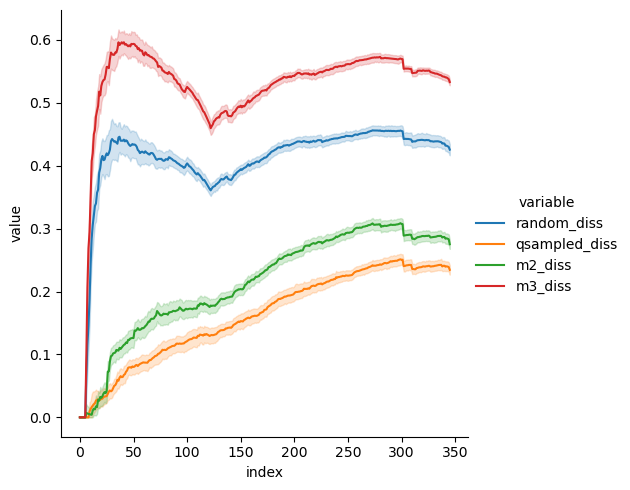

In [10]:
g = sns.relplot(
    data=pd.melt(
        pd.concat(mean_dfs)[
            ["random_diss", "qsampled_diss", "m2_diss", "m3_diss"]
        ].reset_index(),
        id_vars="index",
    ),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)

In [24]:
def _sns_plot_to_df(ax, line_idx=0):
    # get mean
    mean_p_df = pd.DataFrame(
        data={0: ax.lines[line_idx].get_xdata(), 1: ax.lines[line_idx].get_ydata()}
    )

    # get upper/lower conf. bounds
    p = ax.collections[0].get_paths()
    p_df = pd.DataFrame(p[0].vertices).sort_values(by=[0, 1]).drop_duplicates()
    constant_bounds = p_df[~p_df[0].duplicated(keep=False)]
    p_df = pd.concat([p_df, constant_bounds]).sort_values(by=0)
    p_df["lim"] = [
        x
        for y in zip(np.tile("lower", len(mean_p_df)), np.tile("upper", len(mean_p_df)))
        for x in y
    ]

    # merge
    p_df_p = p_df.pivot(index=0, columns="lim").reset_index()
    p_df_p.columns = p_df_p.columns.to_flat_index()
    p_df_p = p_df_p.set_axis(["x", "ci_lower", "ci_upper"], axis="columns")
    df = pd.merge(p_df_p, mean_p_df, how="inner", left_on="x", right_on=0)

    df = df.rename(columns={1: "mean"}).drop(0, axis="columns")
    return df[["x", "mean", "ci_lower", "ci_upper"]]

<AxesSubplot:xlabel='x', ylabel='mean'>

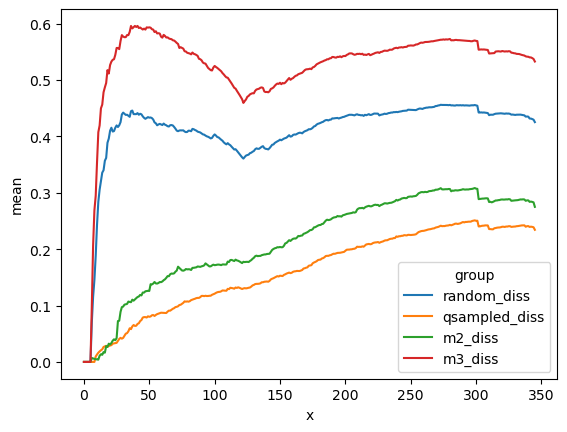

In [47]:
dpt = pd.concat([_sns_plot_to_df(g.figure.gca(), i).assign(group=g.figure.gca().get_legend_handles_labels()[1][i]) for i in range(4)])

sns.lineplot(data=dpt, x="x", y="mean", hue="group")

In [ ]:
dpt.to_csv("data/gibbons_global/global_disson_lin.csv", index=False)

## Log. diss.

In [ ]:
mean_dfs_lg = [
    _compare_dissonance(
        samples,
        glbl["all"],
        glbl["pos"],
        order=entropy_order,
        diss_fcn=_diss_log,
        plot=False,
    )
    for i in tqdm(range(20))
]

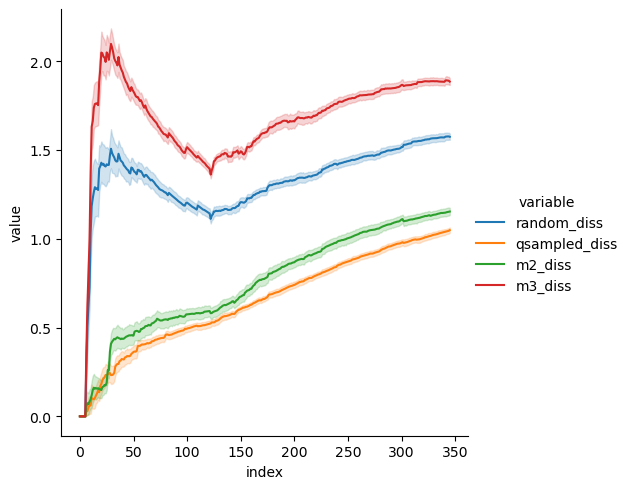

In [49]:
g_lg = sns.relplot(
    data=pd.melt(
        pd.concat(mean_dfs_lg)[
            ["random_diss", "qsampled_diss", "m2_diss", "m3_diss"]
        ].reset_index(),
        id_vars="index",
    ),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)

In [ ]:
print(
    tpl.get_tikz_code(
        g_lg.figure,
        standalone=False,
    )
)

<AxesSubplot:xlabel='x', ylabel='mean'>

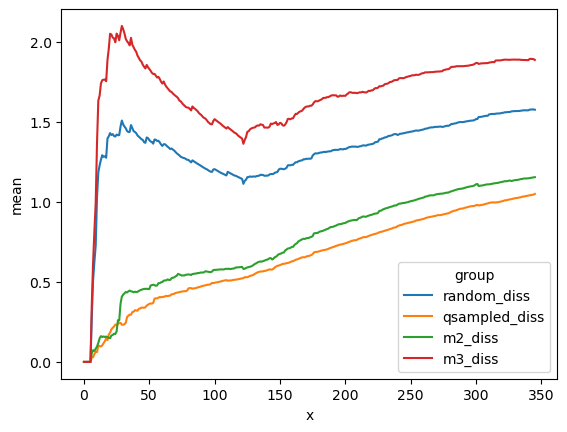

In [50]:
dpt = pd.concat([_sns_plot_to_df(g_lg.figure.gca(), i).assign(group=g_lg.figure.gca().get_legend_handles_labels()[1][i]) for i in range(4)])

sns.lineplot(data=dpt, x="x", y="mean", hue="group")

In [51]:
dpt.to_csv("data/gibbons_global/global_disson_log.csv", index=False)